In [245]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import os
from sys import platform
import f90nml
from importlib import reload
import sys
sys.path.append('../ice2019')
import retrievestuff as rs
import weibull

In [246]:
%matplotlib notebook

In [247]:
def Weibull(Z2,sigma2W,etaW):
    # Getting the Weibull distribution
    rhoW = etaW/(sigma2W)*(Z2/sigma2W)**(etaW-1)*np.exp(-(Z2/sigma2W)**etaW)
    return rhoW

In [248]:
# Have to do this in case of different operating systems
if platform == "linux" or platform == "darwin":
    slash = '/'
else: # This is assumed to be Windows
    slash = '\\'
#print(slash)

In [249]:
# This is the folder name
#foldername = "Fri Mar  1 14_36_55 2019"; 
#filename = "surface.txt"
#foldername = "Fri Mar 29 13_43_02 2019"; filename = "surface.txt"
#foldername = "Case2.0 (calibration)"; filename = "surface_filtered.txt"

isegment = 18
foldername = "2018-07-05"+slash+"Case2.0 (calibration)"; print(foldername);
filename = "surface_filtered"+str(isegment)+".txt"

#Load a height file (for synthetic data)
#filename = "surface.txt"

sollast = np.loadtxt(foldername+slash+filename)
Ny, Nx = np.shape(sollast); #print(sollast.shape)
Ntot = np.size(sollast)
print("Nx =", Nx)
print("Ny =", Ny)
print('Npts = ', Ntot)

# Get other parameters
params = f90nml.read(foldername+slash+'parameters'+str(isegment)+'.nml')
Lx = params['parameters']['Lx']; print("Lx =", Lx)
Ly = params['parameters']['Ly']; print("Ly =", Ly)

2018-07-05\Case2.0 (calibration)
Nx = 41
Ny = 43
Npts =  1763
Lx = 22.808908000000002
Ly = 23.949353400000003


In [250]:
# Get the x and y axes as arrays and grids
x = np.linspace(0,Lx,Nx); #print(x[1]-x[0])
y = np.linspace(0,Ly,Ny); 
xgrid,ygrid = np.meshgrid(x,y); #print(xgrid.shape)
dx = x[1]-x[0]
dy = y[1]-y[0]

<IPython.core.display.Javascript object>


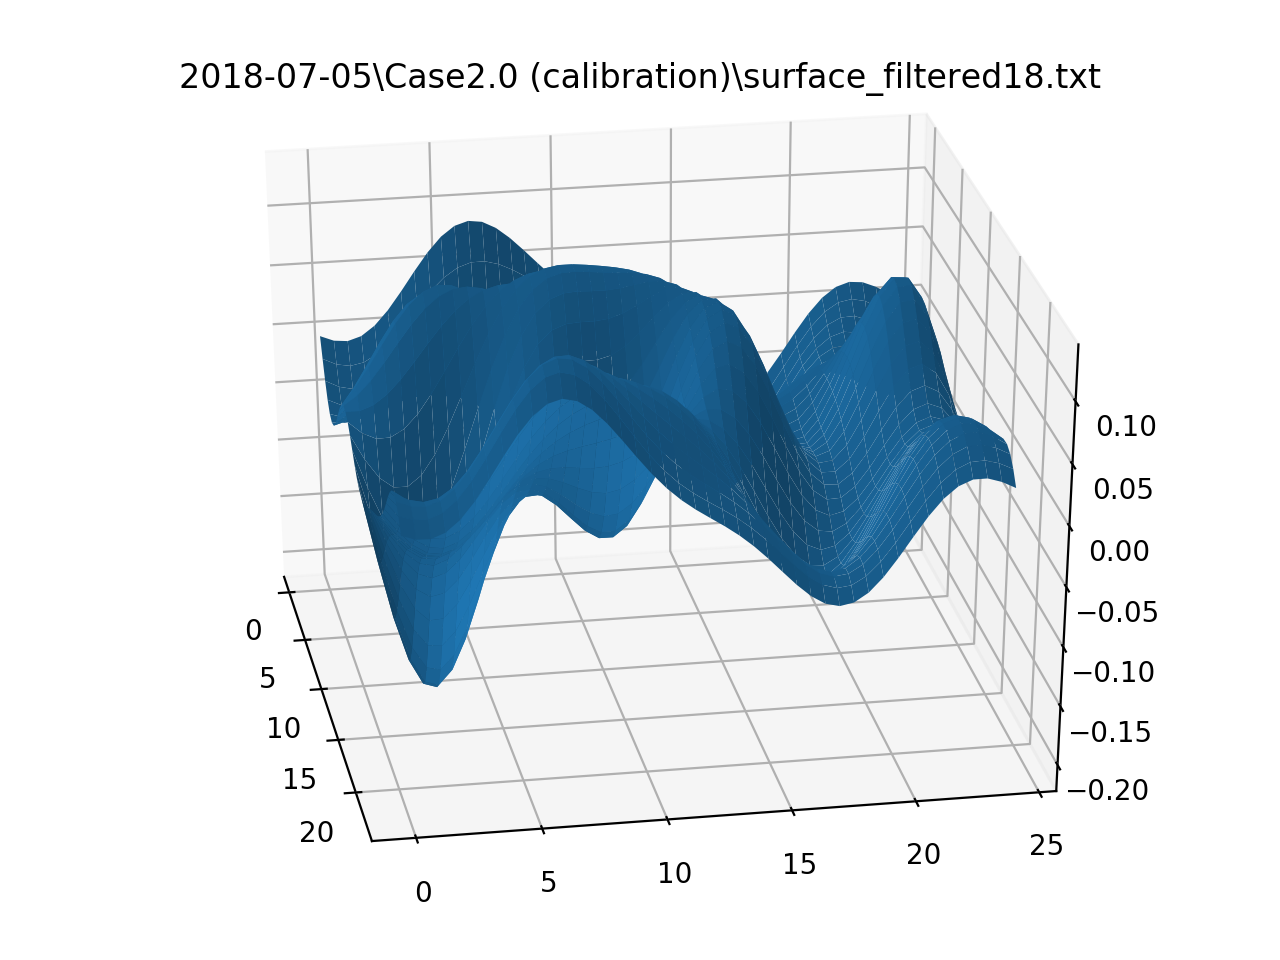

In [251]:
# Plot the surface as a mesh
fig1 = plt.figure()
ax = fig1.add_subplot(111, projection='3d')
ax.plot_surface(xgrid, ygrid, sollast)
ax.set_title(foldername+slash+filename)
ax.view_init(30, -10)

Sturges rule says nbins =  11
Using nbins =  11
Original =  1680
4 0 420 [250 108  43   5   1   6   3   4   0]
4 1 420 [252 110  36   6   6   4   3   3   0]
4 2 420 [257 105  36   6   4   5   6   0   1]
4 3 420 [256 107  37   4   5   4   3   3   1]
ilevelp = 4
ilevelp, t = 4 2.7764451052
meanZ2 =  0.00123679873439
statsigma =  0.0351681494309


<IPython.core.display.Javascript object>


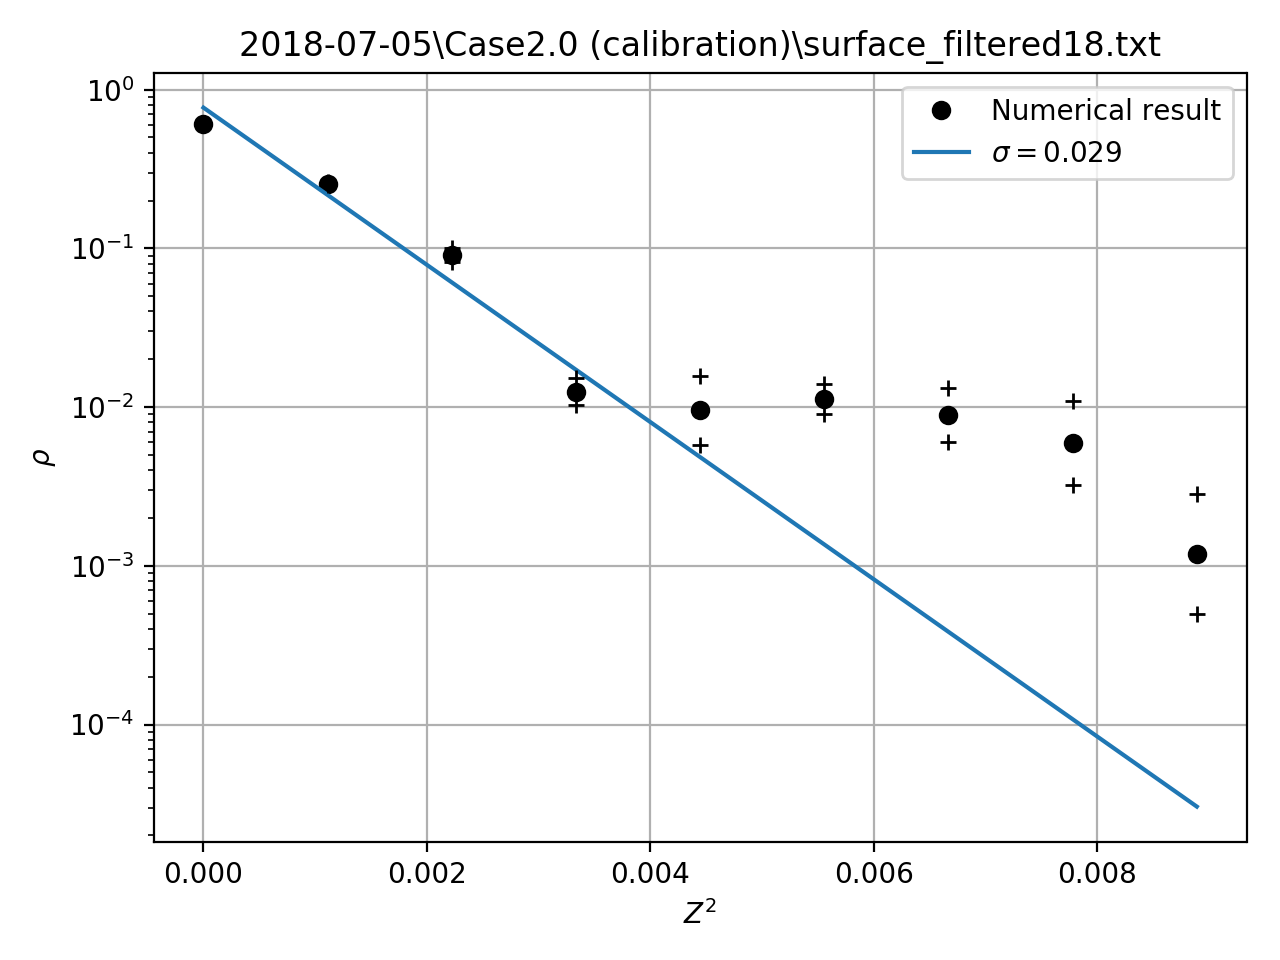

In [252]:
# Get the probability distribution in Z2
nbins_max = 14
nbins_sturges = int(1+3.3*np.log10(Ntot)); print('Sturges rule says nbins = ', nbins_sturges)
nbins = np.min([nbins_max,nbins_sturges]); print('Using nbins = ', nbins)
Z2max = .01
Z2bins = np.linspace(0,Z2max,nbins-1)
counts, bins, meanZ2, error = rs.getrhoofz2(sollast,dx,dy,Z2bins=Z2bins,levels=3)
# print(counts)
# print(error)
print('meanZ2 = ', meanZ2)
print('statsigma = ', np.sqrt(meanZ2))

# Graphing it
fig = plt.figure()
plt.semilogy(bins, counts, 'ok', label='Numerical result')
plt.grid(True)
plt.xlabel('$Z^2$')
plt.ylabel(r'$\rho$')
plt.title(foldername+slash+filename)

# Line fitting
subset = np.array([i for i in range(0,len(bins)-5)])
newbins = bins
logcounts = np.log(counts[subset])
p = np.polyfit(newbins[subset], logcounts, 1)
sigma = 1/(-p[0])**.5
sigma = int(sigma*1000)/1000
plt.semilogy(bins, np.exp(np.polyval(p,bins)), label=r'$\sigma = $'+str(sigma))

# Add a legend
plt.legend()

# Graphing the error bars (sloppily)
countsplus = counts+error
countsminus = counts**2/countsplus
plt.semilogy(bins, countsplus, '+k')
plt.semilogy(bins, countsminus, '+k')


(1680,)
mean Z2 =  0.00123679873439
integral =  0.000774801587302


<IPython.core.display.Javascript object>


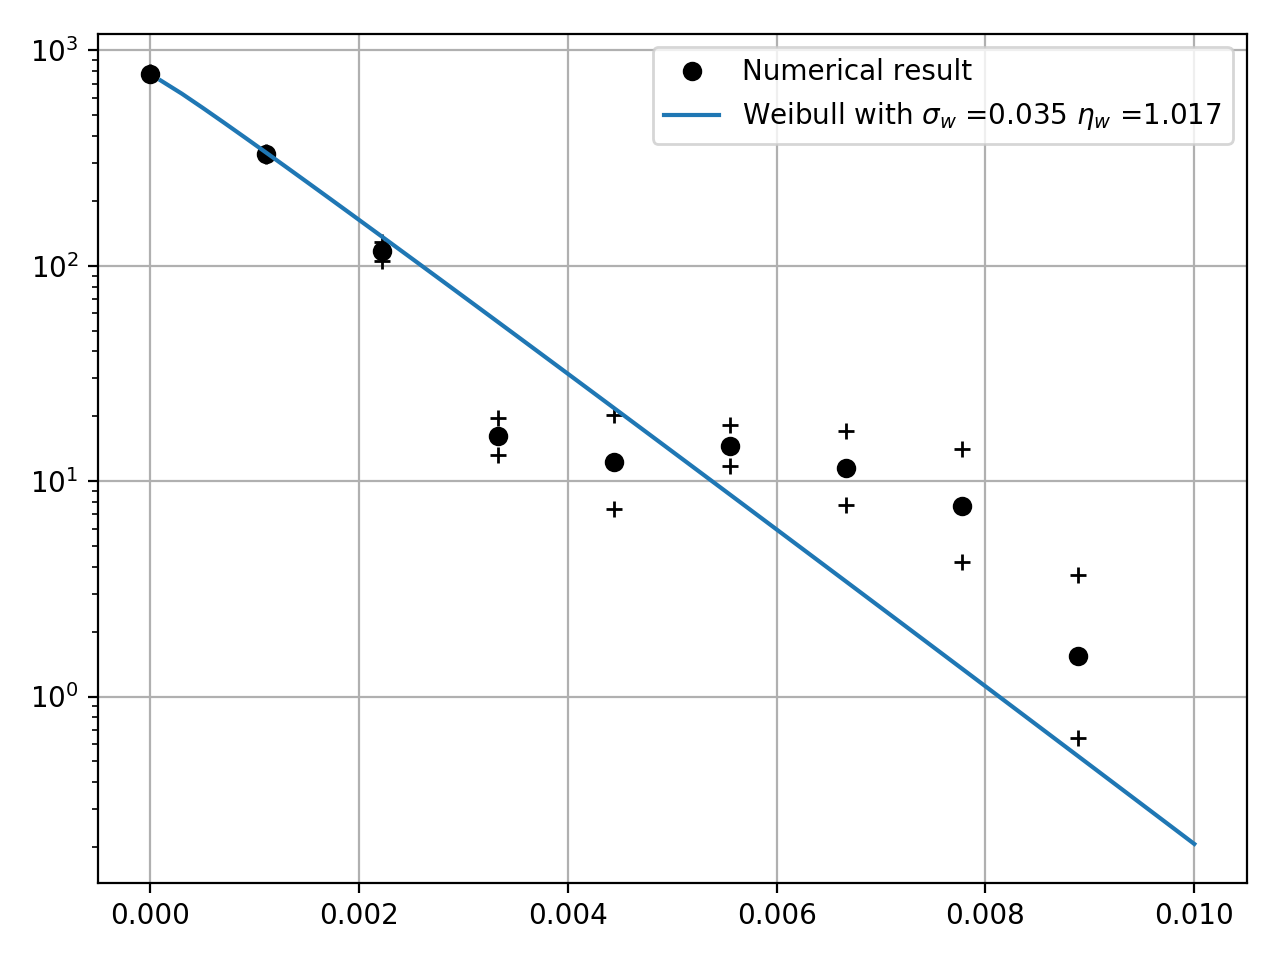

[ 779.76952625  330.34571063  116.77336748   16.13316261   12.29193342
   14.59667093   11.52368758    7.68245839    1.53649168]
[ 791.97613318  338.03632409  129.21074354   19.67033035   20.27286018
   18.13383867   17.06536439   14.08143558    3.66948408]
[  7.67751058e+02   3.22830065e+02   1.05533170e+02   1.32320572e+01
   7.45290136e+00   1.17494595e+01   7.78157281e+00   4.19134587e+00
   6.43362017e-01]


In [253]:
x = np.linspace(0,Lx,Nx)
y = np.linspace(0,Ly,Ny) 
xgrid,ygrid = np.meshgrid(x,y)
dx = x[1]-x[0]
dy = y[1]-y[0]
dzdx = np.diff(sollast, axis=0)/dx
dzdy = np.diff(sollast, axis = 1)/dy #we are not sure which axis is which
Z2 = dzdx[:, 1:]**2+dzdy[1:, :]**2
Z2flat = np.reshape(Z2, (Nx-1)*(Ny-1))
print(np.shape(Z2flat))

# Normalizes the experimental distribution function
print('mean Z2 = ', np.mean(Z2))
integral_rho = np.trapz(counts, bins)
print('integral = ', integral_rho)
counts = counts/integral_rho
error = error/integral_rho

analysis = weibull.Analysis(Z2flat)
analysis.fit(method='mle')
etaW = analysis.beta
sigma2W = analysis.eta
sigmaW = np.sqrt(sigma2W)

fig = plt.figure()
plt.semilogy(bins, counts, 'ok', label='Numerical result')


# Graphing the error bars (sloppily)
print(counts)
countsplus = counts+error; print(countsplus)
countsminus = counts**2/countsplus; print(countsminus)
plt.semilogy(bins, countsplus, '+k')
plt.semilogy(bins, countsminus,'+k')

# Graph the best-fit distribution function
Z2 = np.linspace(0.0001,Z2max,50)
myWeibull = Weibull(Z2,sigma2W,etaW)
plt.semilogy(Z2, myWeibull, label = 'Weibull with $\sigma_w$ =' + str(sigmaW)[0:5] + ' $\eta_w$ =' + str(etaW)[0:5])
plt.grid(True)
plt.legend()


In [254]:
cfile = open(foldername+"/roughness_parameters"+str(isegment)+".nml", "w")
cfile.write('&roughness_parameters\n')
cfile.write('   '+"sigma_W = "+str(sigmaW)+"\n")
cfile.write('   '+"eta_W = "+str(etaW)+"\n")
cfile.write('/ \n')
cfile.close()